# Modelling Rogue Wave Data with Random Forest Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [2]:
import os
import sys
import pickle

sys.path.append('./')
import utils

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")

### Parameter Settings

In [3]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [4]:
undersample = True
num_cv = 10
case = 3

## Building an ElasticNet Regression Model

### Instantiating the Model and Setting Hyperparameters

- `l1_ratio`: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- `selection`: If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

In [5]:
hyperparameter_grid = { 
    'l1_ratio': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1],
    'selection': ['cyclic', 'random'] 
}

In [6]:
def elnet_model(seed, X_train, X_test, y_train_cat, y_train, y_test):
    regressor = ElasticNet(random_state=seed)

    scaler = StandardScaler()
    X_train_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)

    # Tune hyperparameters
    skf = StratifiedKFold(n_splits=num_cv).split(X_train_transformed, y_train_cat)

    gridsearch_classifier = GridSearchCV(regressor, hyperparameter_grid, cv=skf)
    gridsearch_classifier.fit(X_train_transformed, y_train)

    # Check the results
    print(f'\nThe mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_, 3)} and the parameters of best prediction model are:')
    print(gridsearch_classifier.best_params_)

    # Take the best estimator
    model = gridsearch_classifier.best_estimator_

    # Predict labels
    y_pred = model.predict(X_train_transformed)
    y_true = y_train

    print(f"\nTrain set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

    # Predict labels
    y_pred = model.predict(X_test_transformed)
    y_true = y_test

    print(f"\nTest set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and Spearman correlation.

We load the case 3 data that was preprocessed in `data_preprocessing.ipynb`.  

Case 3: 
- class 0: target < 1.5
- class 1: 1.5 < target < 2.0  
- class 2: target > 2.0

Building model for case 3 with random undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})

The mean cross-validated score of the best model is 0.132 and the parameters of best prediction model are:
{'l1_ratio': 0, 'selection': 'cyclic'}

Train set MSE: 0.085
Train set R^2: 0.132
Train set Spearman R: 0.379


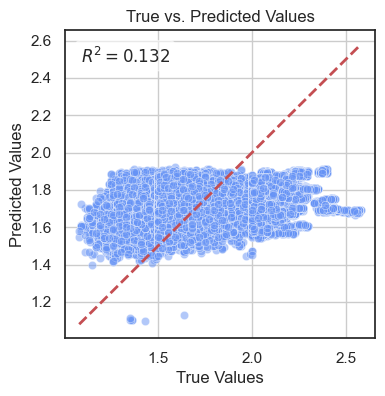


Test set MSE: 0.053
Test set R^2: -0.765
Test set Spearman R: 0.226


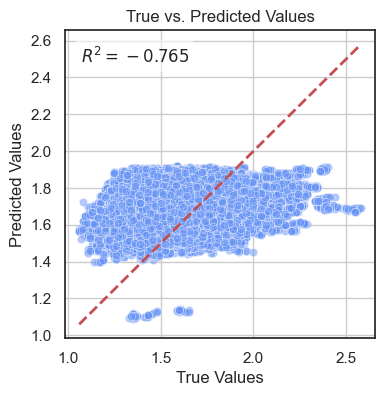

In [7]:
undersample_method = "random"

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""}.')
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)
elnet_model(seed, X_train, X_test, y_train_cat, y_train, y_test)

Building model for case 3 with nearmiss undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})

The mean cross-validated score of the best model is 0.006 and the parameters of best prediction model are:
{'l1_ratio': 0, 'selection': 'cyclic'}

Train set MSE: 0.09
Train set R^2: 0.027
Train set Spearman R: 0.181


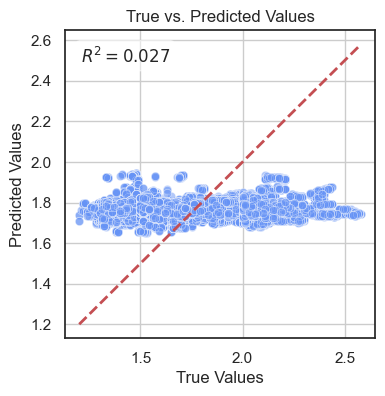


Test set MSE: 0.078
Test set R^2: -1.59
Test set Spearman R: 0.054


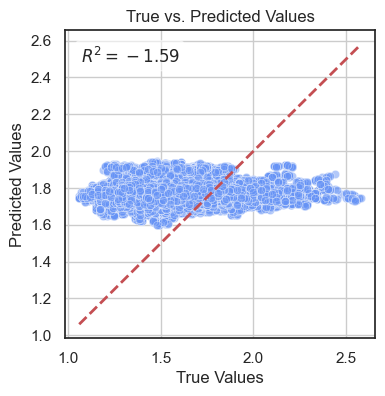

In [8]:
undersample_method = "nearmiss"

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""}.')
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)
elnet_model(seed, X_train, X_test, y_train_cat, y_train, y_test)

## Building a Random Forest Regression Model

### Instantiating the Model and Setting Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
- `criterion`: The function to measure the quality of a split. Supported criteria are “squared_error” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, “absolute_error” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node, and “poisson” which uses reduction in Poisson deviance to find splits. Training using “absolute_error” is significantly slower than when using “squared_error”.
- `max_features`: The number of features to consider when looking for the best split.

In [9]:
hyperparameter_grid = {'n_estimators': [1000], 
            'max_depth': [10, 20, 30, 50], 
            'max_samples': [0.5, 0.8, 0.95],
            'criterion': ['squared_error', 'poisson','friedman_mse'],
            'max_features': ['sqrt','log2'],
}

In [10]:
def rf_model(seed, X_train, X_test, y_train_cat, y_train, y_test):
    # Define the classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
    regressor = RandomForestRegressor(oob_score=True, random_state=seed)

    # Tune hyperparameters
    skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)

    gridsearch_classifier = GridSearchCV(regressor, hyperparameter_grid, cv=skf)
    gridsearch_classifier.fit(X_train, y_train)

    # Check the results
    print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_, 3)} and the parameters of best prediction model are:')
    print(gridsearch_classifier.best_params_)

    # Take the best estimator
    model = gridsearch_classifier.best_estimator_

    # Predict labels
    y_pred = model.predict(X_train)
    y_true = y_train

    print(f"\nTrain set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

    # Predict labels
    y_pred = model.predict(X_test)
    y_true = y_test

    print(f"\nTest set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

    # Save the model
    data_and_model = [data_train, data_test, model]

    with open(f'../models/reg_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'wb') as handle:
        pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and Spearman correlation.

We load the case 3 data that was preprocessed in `data_preprocessing.ipynb`.  

Case 3: 
- class 0: target < 1.5
- class 1: 1.5 < target < 2.0  
- class 2: target > 2.0

Building model for case 3 with random undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
The mean cross-validated score of the best model is 0.926 and the parameters of best prediction model are:
{'criterion': 'poisson', 'max_depth': 50, 'max_features': 'sqrt', 'max_samples': 0.95, 'n_estimators': 1000}

Train set MSE: 0.001
Train set R^2: 0.99
Train set Spearman R: 0.994


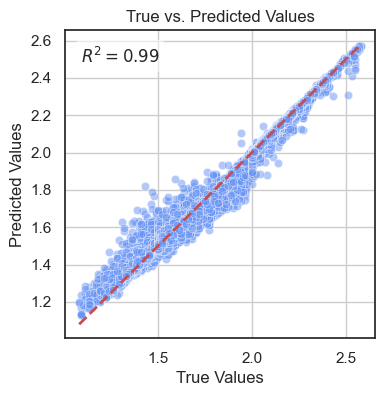


Test set MSE: 0.01
Test set R^2: 0.674
Test set Spearman R: 0.806


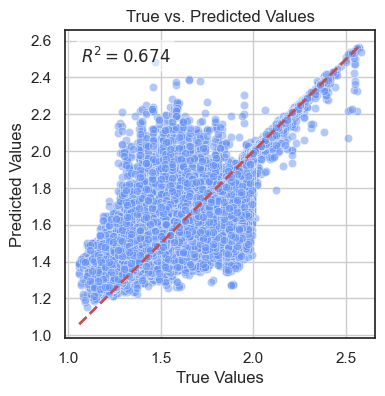

In [11]:
undersample_method = "random"

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""}.')
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)
rf_model(seed, X_train, X_test, y_train_cat, y_train, y_test)

Building model for case 3 with nearmiss undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
The mean cross-validated score of the best model is 0.874 and the parameters of best prediction model are:
{'criterion': 'poisson', 'max_depth': 50, 'max_features': 'sqrt', 'max_samples': 0.95, 'n_estimators': 1000}

Train set MSE: 0.0
Train set R^2: 0.995
Train set Spearman R: 0.996


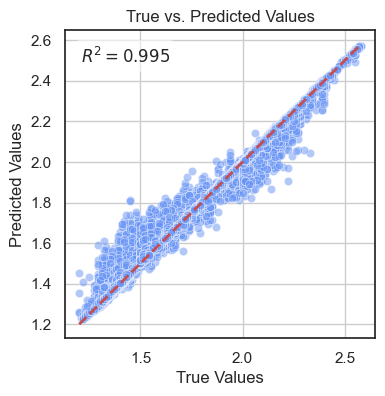


Test set MSE: 0.058
Test set R^2: -0.934
Test set Spearman R: 0.14


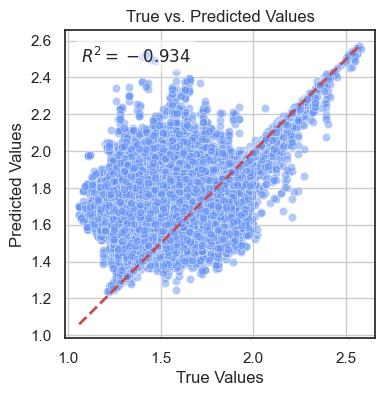

In [12]:
undersample_method = "nearmiss"

print(f'Building model for case {case}' + f'{f" with {undersample_method} undersampled data" if undersample else ""}.')
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)
rf_model(seed, X_train, X_test, y_train_cat, y_train, y_test)